add gaussian noise to the data and see how that influences the wMAPE for prediction

In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
case = 'bimodal'
case = 'unimodal'

### Config

In [4]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory

'/data/user/boiger_r/aerosol'

In [5]:
#unimodal case
if case == 'unimodal':
    test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-450-532-630_sc-None_qoi-ScatteringData/test_dataset.hdf5'

#bimodal case
elif case == 'bimodal':
    test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_bimodal_AAE/pre_log_ts-0.2_wl-450-532-630_sc-None_qoi-ScatteringData_21_55/test_dataset.hdf5'





In [6]:
model_name = 'invertible_model'

val_model_name = 'forward_model'

In [7]:
#unimodal case
if case == 'unimodal':
    directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'

#bimodal case
elif case == 'bimodal':
    directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_bim_AAE/'




In [8]:
plot_dir = directory1 + 'version1/plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory1 + 'version1/model'

### Load Model & Data

In [9]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [10]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [11]:
qoi_test

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.281905   -14.332187   -14.477527   -14.704235   -14.995637   
1       -15.369892   -15.391272   -15.454429   -15.556539   -15.693613   
2       -13.163498   -13.269936   -13.568338   -14.012243   -14.553216   
3       -14.734229   -14.736286   -14.742458   -14.752693   -14.766988   
4       -14.615775   -14.634811   -14.691043   -14.781832   -14.903598   
...            ...          ...          ...          ...          ...   
19995   -13.471070   -13.530708   -13.702360   -13.968277   -14.307416   
19996   -13.582496   -13.669853   -13.917488   -14.292192   -14.757324   
19997   -15.110758   -15.114857   -15.127031   -15.147241   -15.175241   
19998   -13.720382   -13.769295   -13.911328   -14.134009   -14.421893   
19999   -13.613795   -13.728049   -14.043843   -14.504845   -15.056597   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604  ...   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644  ...   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654  ...   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381  ...   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732  ...   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948  ...   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911  ...   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326  ...   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064713       0.073603       0.063783       0.042183   
1           0.015491       0.012088       0.008447       0.005066   
2           0.006125       0.004613       0.003166       0.001884   
3          -0.004652      -0.003351      -0.002209      -0.001271   
4          -0.092306      -0.061773      -0.037827      -0.020372   
...              ...            ...            ...            ...   
19995       0.051331       0.075070       0.073761       0.051904   
19996      -0.027905      -0.049690      -0.051267      -0.034185   
19997      -0.054749      -0.038806      -0.025225      -0.014351   
19998      -0.228760      -0.181380      -0.127360      -0.075856   
19999       0.026723       0.028192       0.024330       0.016850   

       P12_0.630_178  P12_0.630_179  
0           0.020225       0.005215  
1           0.002352       0.000603  
2           0.000872       0.000224  
3          -0.000574      -0.000145  
4          -0.008731      -0.002131  
...              ...            ...  
19995       0.025579       0.006666  
19996      -0.014282      -0.003060  
19997      -0.006427      -0.001614  
19998      -0.034748      -0.008803  
19999       0.008576       0.002313  

[20000 rows x 1077 columns]

In [12]:
dvar_test

V_tot  R_median       GSD         n     k_532       AAE
0      2315.678911  1.360143  1.422027  1.345160  0.060143  5.833945
1      1121.450456  0.871451  1.422156  1.560918  0.172217  1.027340
2      4962.553150  2.033473  1.405489  1.556752  0.179643  1.194336
3      4874.291655  0.258148  1.404925  1.331706  0.039514  4.331665
4      2536.972303  0.806500  1.444872  1.436442  0.118185  3.215479
...            ...       ...       ...       ...       ...       ...
19995  4764.529527  1.494872  1.414259  1.333477  0.047427  4.642539
19996  3534.192530  1.835515  1.405211  1.468337  0.012928  5.740662
19997  2015.697397  0.385029  1.430910  1.390257  0.042194  3.183546
19998  3989.475902  1.355483  1.409619  1.563611  0.013500  4.484978
19999  3102.600374  2.073354  1.426555  1.338385  0.098061  1.239737

[20000 rows x 6 columns]

### Add Rel. Gaussian Error onto Scattering Data

In [13]:
def add_relative_gaussian_noise(dataFrame, relative_error=0.05, seed=42):
    """ Add gaussian noise with a given relative error to dataFrame
        according to the following formula:
       [(1 + rel_error * gauss(mean=0, std=0.5)]*dataFrame.
    Input:
            dataFrame       : pandas DataFrame containing the simulated observed data
            relative_error  : float between 0 and 1
            seed            : int seed for numpy's random generator
    Output:
            dataFrame_np_w_noise :  pandas DataFrame containing the data with
                                    noise added
    We assume that the relative error is associated to a confidence intervall with a
    p-value of p = 0.9545. Consequently, the standarddeviation is set to 0.5
    so that statistically about 95% of N samples are found in the interval [0,1].
    """
    dataFrame_np = dataFrame.to_numpy()
    # If one wishes to change the p-value, the standard deviation in the next line must be changed
    noise = relative_error * np.random.normal(0, 0.5, dataFrame_np.shape)
    dataFrame_np_w_noise = pd.DataFrame((1 + noise) * dataFrame_np,
                                        columns=dataFrame.keys())
    return dataFrame_np_w_noise

In [14]:
def add_absolute_gaussian_noise(dataFrame, absolute_error = 0.0025, seed = 42):
    
    
    mu = 0.05
    sigma = absolute_error  
    # creating a noise with the same dimension as the dataset (2,2) 
    noise = np.random.normal(mu, sigma, dataFrame.shape) 
    dataFrame_w_noise = dataFrame + noise
    
    return dataFrame_w_noise

In [15]:
P_11_column_names = list(filter(re.compile(".*P11").match, qoi_test.columns))
P_12_column_names = list(filter(re.compile(".*P12").match, qoi_test.columns))
P_11_column_names

['P11_0.450_0',
 'P11_0.450_1',
 'P11_0.450_2',
 'P11_0.450_3',
 'P11_0.450_4',
 'P11_0.450_5',
 'P11_0.450_6',
 'P11_0.450_7',
 'P11_0.450_8',
 'P11_0.450_9',
 'P11_0.450_10',
 'P11_0.450_11',
 'P11_0.450_12',
 'P11_0.450_13',
 'P11_0.450_14',
 'P11_0.450_15',
 'P11_0.450_16',
 'P11_0.450_17',
 'P11_0.450_18',
 'P11_0.450_19',
 'P11_0.450_20',
 'P11_0.450_21',
 'P11_0.450_22',
 'P11_0.450_23',
 'P11_0.450_24',
 'P11_0.450_25',
 'P11_0.450_26',
 'P11_0.450_27',
 'P11_0.450_28',
 'P11_0.450_29',
 'P11_0.450_30',
 'P11_0.450_31',
 'P11_0.450_32',
 'P11_0.450_33',
 'P11_0.450_34',
 'P11_0.450_35',
 'P11_0.450_36',
 'P11_0.450_37',
 'P11_0.450_38',
 'P11_0.450_39',
 'P11_0.450_40',
 'P11_0.450_41',
 'P11_0.450_42',
 'P11_0.450_43',
 'P11_0.450_44',
 'P11_0.450_45',
 'P11_0.450_46',
 'P11_0.450_47',
 'P11_0.450_48',
 'P11_0.450_49',
 'P11_0.450_50',
 'P11_0.450_51',
 'P11_0.450_52',
 'P11_0.450_53',
 'P11_0.450_54',
 'P11_0.450_55',
 'P11_0.450_56',
 'P11_0.450_57',
 'P11_0.450_58',
 'P11_0

In [16]:
qoi_test

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.281905   -14.332187   -14.477527   -14.704235   -14.995637   
1       -15.369892   -15.391272   -15.454429   -15.556539   -15.693613   
2       -13.163498   -13.269936   -13.568338   -14.012243   -14.553216   
3       -14.734229   -14.736286   -14.742458   -14.752693   -14.766988   
4       -14.615775   -14.634811   -14.691043   -14.781832   -14.903598   
...            ...          ...          ...          ...          ...   
19995   -13.471070   -13.530708   -13.702360   -13.968277   -14.307416   
19996   -13.582496   -13.669853   -13.917488   -14.292192   -14.757324   
19997   -15.110758   -15.114857   -15.127031   -15.147241   -15.175241   
19998   -13.720382   -13.769295   -13.911328   -14.134009   -14.421893   
19999   -13.613795   -13.728049   -14.043843   -14.504845   -15.056597   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604  ...   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644  ...   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654  ...   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381  ...   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732  ...   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948  ...   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911  ...   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326  ...   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064713       0.073603       0.063783       0.042183   
1           0.015491       0.012088       0.008447       0.005066   
2           0.006125       0.004613       0.003166       0.001884   
3          -0.004652      -0.003351      -0.002209      -0.001271   
4          -0.092306      -0.061773      -0.037827      -0.020372   
...              ...            ...            ...            ...   
19995       0.051331       0.075070       0.073761       0.051904   
19996      -0.027905      -0.049690      -0.051267      -0.034185   
19997      -0.054749      -0.038806      -0.025225      -0.014351   
19998      -0.228760      -0.181380      -0.127360      -0.075856   
19999       0.026723       0.028192       0.024330       0.016850   

       P12_0.630_178  P12_0.630_179  
0           0.020225       0.005215  
1           0.002352       0.000603  
2           0.000872       0.000224  
3          -0.000574      -0.000145  
4          -0.008731      -0.002131  
...              ...            ...  
19995       0.025579       0.006666  
19996      -0.014282      -0.003060  
19997      -0.006427      -0.001614  
19998      -0.034748      -0.008803  
19999       0.008576       0.002313  

[20000 rows x 1077 columns]

In [17]:
P11_test = np.exp(qoi_test[P_11_column_names])
P12_test = qoi_test[P_12_column_names]

In [18]:
P11_test

P11_0.450_0   P11_0.450_1   P11_0.450_2   P11_0.450_3   P11_0.450_4  \
0      6.272600e-07  5.965000e-07  5.158100e-07  4.111800e-07  3.072400e-07   
1      2.113200e-07  2.068500e-07  1.941900e-07  1.753400e-07  1.528800e-07   
2      1.919400e-06  1.725600e-06  1.280400e-06  8.214100e-07  4.782100e-07   
3      3.990300e-07  3.982100e-07  3.957600e-07  3.917300e-07  3.861700e-07   
4      4.492100e-07  4.407400e-07  4.166400e-07  3.804800e-07  3.368600e-07   
...             ...           ...           ...           ...           ...   
19995  1.411200e-06  1.329500e-06  1.119800e-06  8.583300e-07  6.114600e-07   
19996  1.262400e-06  1.156800e-06  9.030500e-07  6.208400e-07  3.899200e-07   
19997  2.738300e-07  2.727100e-07  2.694100e-07  2.640200e-07  2.567300e-07   
19998  1.099800e-06  1.047300e-06  9.086300e-07  7.272400e-07  5.453200e-07   
19999  1.223500e-06  1.091400e-06  7.958600e-07  5.019100e-07  2.890700e-07   

        P11_0.450_5   P11_0.450_6   P11_0.450_7   P11_0.450_8   P11_0.450_9  \
0      2.186400e-07  1.503200e-07  1.011400e-07  6.737900e-08  4.495500e-08   
1      1.292900e-07  1.065400e-07  8.592300e-08  6.809200e-08  5.323000e-08   
2      2.638400e-07  1.437400e-07  8.037500e-08  4.785000e-08  3.080300e-08   
3      3.791900e-07  3.708800e-07  3.613600e-07  3.507900e-07  3.393000e-07   
4      2.903400e-07  2.446100e-07  2.022300e-07  1.646400e-07  1.324400e-07   
...             ...           ...           ...           ...           ...   
19995  4.129300e-07  2.691000e-07  1.720200e-07  1.095300e-07  7.056500e-08   
19996  2.313800e-07  1.339000e-07  7.792800e-08  4.704000e-08  3.015400e-08   
19997  2.477900e-07  2.374600e-07  2.260200e-07  2.137800e-07  2.010100e-07   
19998  3.890800e-07  2.680300e-07  1.807600e-07  1.209600e-07  8.144600e-08   
19999  1.590500e-07  8.701800e-08  4.899900e-08  2.932400e-08  1.885300e-08   

       ...  P11_0.630_170  P11_0.630_171  P11_0.630_172  P11_0.630_173  \
0      ...   2.947600e-10   2.609400e-10   2.266200e-10   1.978400e-10   
1      ...   6.876500e-11   6.960700e-11   7.068500e-11   7.193400e-11   
2      ...   1.068100e-10   1.069000e-10   1.070300e-10   1.072100e-10   
3      ...   1.611000e-09   1.627000e-09   1.642000e-09   1.655700e-09   
4      ...   1.883600e-10   1.830000e-10   1.809300e-10   1.820500e-10   
...    ...            ...            ...            ...            ...   
19995  ...   5.546700e-10   5.002300e-10   4.379900e-10   3.800300e-10   
19996  ...   1.731300e-09   1.692400e-09   1.608000e-09   1.472800e-09   
19997  ...   7.399400e-10   7.485700e-10   7.582900e-10   7.687800e-10   
19998  ...   3.718700e-09   3.938100e-09   4.171800e-09   4.438300e-09   
19999  ...   3.515200e-11   3.420400e-11   3.320500e-11   3.233300e-11   

       P11_0.630_174  P11_0.630_175  P11_0.630_176  P11_0.630_177  \
0       1.801000e-10   1.767900e-10   1.880100e-10   2.098800e-10   
1       7.327500e-11   7.461900e-11   7.587700e-11   7.696000e-11   
2       1.074100e-10   1.076300e-10   1.078500e-10   1.080500e-10   
3       1.668100e-09   1.678800e-09   1.687800e-09   1.695000e-09   
4       1.859200e-10   1.917800e-10   1.986500e-10   2.054700e-10   
...              ...            ...            ...            ...   
19995   3.389200e-10   3.242900e-10   3.395400e-10   3.791100e-10   
19996   1.303900e-09   1.144700e-09   1.049900e-09   1.059600e-09   
19997   7.795700e-10   7.901200e-10   7.998200e-10   8.080800e-10   
19998   4.763200e-09   5.168700e-09   5.659400e-09   6.201800e-09   
19999   3.174900e-11   3.155500e-11   3.174900e-11   3.222100e-11   

       P11_0.630_178  P11_0.630_179  
0       2.350500e-10   2.548600e-10  
1       7.779500e-11   7.832000e-11  
2       1.082100e-10   1.083100e-10  
3       1.700200e-09   1.703400e-09  
4       2.112100e-10   2.150200e-10  
...              ...            ...  
19995   4.284800e-10   4.687900e-10  
19996   1.166700e-09   1.302400e-09  
19997   8.143900e-10   8.183400e-10  
19998   6.71

In [19]:
P11_test_noise = add_relative_gaussian_noise(P11_test)
P12_test_noise = add_relative_gaussian_noise(P12_test)

In [20]:
P12_test_noise

P12_0.450_1  P12_0.450_2  P12_0.450_3  P12_0.450_4  P12_0.450_5  \
0         0.000192     0.000722     0.001722     0.002942     0.004516   
1         0.000116     0.000480     0.001069     0.001848     0.002893   
2         0.000361     0.001447     0.003174     0.006206     0.009665   
3         0.000055     0.000220     0.000495     0.000894     0.001376   
4         0.000134     0.000536     0.001138     0.002005     0.003195   
...            ...          ...          ...          ...          ...   
19995     0.000086     0.000334     0.000771     0.001330     0.002163   
19996    -0.000104    -0.000403    -0.000849    -0.001235    -0.001167   
19997    -0.000002    -0.000009    -0.000021    -0.000041    -0.000068   
19998    -0.000109    -0.000425    -0.000868    -0.001492    -0.001993   
19999     0.000197     0.000700     0.001720     0.003057     0.005224   

       P12_0.450_6  P12_0.450_7  P12_0.450_8  P12_0.450_9  P12_0.450_10  ...  \
0         0.006843     0.009793     0.012904     0.016668      0.023338  ...   
1         0.004243     0.005654     0.007640     0.009624      0.013577  ...   
2         0.016260     0.026316     0.036695     0.053586      0.067523  ...   
3         0.001930     0.002776     0.003309     0.004547      0.005701  ...   
4         0.004438     0.006332     0.008186     0.009944      0.012282  ...   
...            ...          ...          ...          ...           ...  ...   
19995     0.003227     0.005078     0.007828     0.011799      0.017458  ...   
19996    -0.000007     0.003184     0.009337     0.018289      0.029502  ...   
19997    -0.000111    -0.000168    -0.000238    -0.000345     -0.000465  ...   
19998    -0.002204    -0.001950    -0.000438     0.002752      0.007929  ...   
19999     0.009151     0.013724     0.020666     0.029328      0.039983  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.008926       0.010546       0.022955       0.044825   
1           0.015524       0.018944       0.019462       0.017793   
2           0.011548       0.010116       0.008989       0.007487   
3          -0.010138      -0.009341      -0.007361      -0.006090   
4          -0.242768      -0.207243      -0.164477      -0.125633   
...              ...            ...            ...            ...   
19995      -0.027714      -0.026446      -0.011316       0.016927   
19996       0.119710       0.080188       0.046949       0.006112   
19997      -0.126391      -0.111391      -0.090113      -0.072231   
19998      -0.266063      -0.272268      -0.282464      -0.262642   
19999      -0.009712      -0.000818       0.010066       0.020302   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064708       0.070858       0.065730       0.043860   
1           0.015499       0.012499       0.008073       0.005092   
2           0.005858       0.004556       0.003325       0.001861   
3          -0.004658      -0.003293      -0.002223      -0.001343   
4          -0.089890      -0.060512      -0.038101      -0.020554   
...              ...            ...            ...            ...   
19995       0.049774       0.076216       0.076981       0.052316   
19996      -0.027695      -0.049501      -0.049937      -0.033804   
19997      -0.055867      -0.037519      -0.025599      -0.014128   
19998      -0.234267      -0.180273      -0.128291      -0.076937   
19999       0.026814       0.028382       0.024442       0.016949   

       P12_0.630_178  P12_0.630_179  
0           0.020169       0.005328  
1           0.002297       0.000589  
2           0.000866       0.000217  
3          -0.000584      -0.000144  
4          -0.008822      -0.002138  
...              ...            ...  
19995       0.025972       0.006552  
19996      -0.014027      -0.003219  
19997      -0.006734      -0.001695  
19998      -0.034614      -0.008678  
19999       0.008682       0.002328  

[20000 rows x 537 columns]

In [21]:
P12_test

P12_0.450_1  P12_0.450_2  P12_0.450_3  P12_0.450_4  P12_0.450_5  \
0         0.000193     0.000760     0.001685     0.002960     0.004611   
1         0.000117     0.000468     0.001050     0.001861     0.002909   
2         0.000350     0.001392     0.003169     0.005881     0.009973   
3         0.000055     0.000218     0.000491     0.000873     0.001365   
4         0.000133     0.000530     0.001181     0.002074     0.003199   
...            ...          ...          ...          ...          ...   
19995     0.000084     0.000330     0.000733     0.001312     0.002132   
19996    -0.000108    -0.000411    -0.000837    -0.001205    -0.001147   
19997    -0.000002    -0.000009    -0.000021    -0.000041    -0.000070   
19998    -0.000109    -0.000423    -0.000905    -0.001479    -0.002010   
19999     0.000194     0.000758     0.001697     0.003121     0.005305   

       P12_0.450_6  P12_0.450_7  P12_0.450_8  P12_0.450_9  P12_0.450_10  ...  \
0         0.006700     0.009345     0.012717     0.017033      0.022500  ...   
1         0.004210     0.005799     0.007726     0.010066      0.012920  ...   
2         0.016153     0.025217     0.037415     0.052252      0.067728  ...   
3         0.001966     0.002678     0.003500     0.004432      0.005475  ...   
4         0.004551     0.006130     0.007942     0.010004      0.012337  ...   
...            ...          ...          ...          ...           ...  ...   
19995     0.003326     0.005128     0.007879     0.011995      0.017822  ...   
19996    -0.000008     0.003164     0.009321     0.018782      0.030510  ...   
19997    -0.000111    -0.000168    -0.000243    -0.000342     -0.000469  ...   
19998    -0.002272    -0.001912    -0.000436     0.002756      0.008208  ...   
19999     0.008706     0.013893     0.021166     0.030441      0.040577  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064713       0.073603       0.063783       0.042183   
1           0.015491       0.012088       0.008447       0.005066   
2           0.006125       0.004613       0.003166       0.001884   
3          -0.004652      -0.003351      -0.002209      -0.001271   
4          -0.092306      -0.061773      -0.037827      -0.020372   
...              ...            ...            ...            ...   
19995       0.051331       0.075070       0.073761       0.051904   
19996      -0.027905      -0.049690      -0.051267      -0.034185   
19997      -0.054749      -0.038806      -0.025225      -0.014351   
19998      -0.228760      -0.181380      -0.127360      -0.075856   
19999       0.026723       0.028192       0.024330       0.016850   

       P12_0.630_178  P12_0.630_179  
0           0.020225       0.005215  
1           0.002352       0.000603  
2           0.000872       0.000224  
3          -0.000574      -0.000145  
4          -0.008731      -0.002131  
...              ...            ...  
19995       0.025579       0.006666  
19996      -0.014282      -0.003060  
19997      -0.006427      -0.001614  
19998      -0.034748      -0.008803  
19999       0.008576       0.002313  

[20000 rows x 537 columns]

In [22]:
qoi_test_noise = pd.concat([np.log(P11_test_noise), P12_test_noise], axis=1)

In [23]:
qoi_test_noise

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.290699   -14.329150   -14.485672   -14.776817   -14.978631   
1       -15.406128   -15.374837   -15.450577   -15.594108   -15.705250   
2       -13.157311   -13.197555   -13.595423   -14.016987   -14.530488   
3       -14.733590   -14.774480   -14.751284   -14.740864   -14.794356   
4       -14.578021   -14.658187   -14.676654   -14.733350   -14.902691   
...            ...          ...          ...          ...          ...   
19995   -13.469008   -13.519867   -13.692284   -14.008227   -14.296526   
19996   -13.573700   -13.662991   -13.898807   -14.281943   -14.750638   
19997   -15.143428   -15.128838   -15.092545   -15.126134   -15.150406   
19998   -13.748361   -13.777961   -13.890949   -14.126392   -14.386948   
19999   -13.627814   -13.779676   -14.052258   -14.512333   -15.074444   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.348690   -15.690324   -16.117032   -16.481045   -16.904129  ...   
1       -15.870579   -16.073651   -16.295046   -16.475034   -16.762263  ...   
2       -15.164459   -15.735750   -16.359462   -16.876631   -17.227074  ...   
3       -14.765228   -14.814492   -14.811919   -14.877883   -14.887227  ...   
4       -15.079758   -15.260427   -15.408763   -15.627871   -15.838360  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.740472   -15.131947   -15.561976   -16.002547   -16.460671  ...   
19996   -15.260123   -15.846061   -16.410074   -16.847903   -17.391772  ...   
19997   -15.164422   -15.261665   -15.296065   -15.384308   -15.389401  ...   
19998   -14.730265   -15.133250   -15.507974   -15.886970   -16.330968  ...   
19999   -15.686426   -16.300053   -16.843791   -17.355294   -17.778983  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.008926       0.010546       0.022955       0.044825   
1           0.015524       0.018944       0.019462       0.017793   
2           0.011548       0.010116       0.008989       0.007487   
3          -0.010138      -0.009341      -0.007361      -0.006090   
4          -0.242768      -0.207243      -0.164477      -0.125633   
...              ...            ...            ...            ...   
19995      -0.027714      -0.026446      -0.011316       0.016927   
19996       0.119710       0.080188       0.046949       0.006112   
19997      -0.126391      -0.111391      -0.090113      -0.072231   
19998      -0.266063      -0.272268      -0.282464      -0.262642   
19999      -0.009712      -0.000818       0.010066       0.020302   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064708       0.070858       0.065730       0.043860   
1           0.015499       0.012499       0.008073       0.005092   
2           0.005858       0.004556       0.003325       0.001861   
3          -0.004658      -0.003293      -0.002223      -0.001343   
4          -0.089890      -0.060512      -0.038101      -0.020554   
...              ...            ...            ...            ...   
19995       0.049774       0.076216       0.076981       0.052316   
19996      -0.027695      -0.049501      -0.049937      -0.033804   
19997      -0.055867      -0.037519      -0.025599      -0.014128   
19998      -0.234267      -0.180273      -0.128291      -0.076937   
19999       0.026814       0.028382       0.024442       0.016949   

       P12_0.630_178  P12_0.630_179  
0           0.020169       0.005328  
1           0.002297       0.000589  
2           0.000866       0.000217  
3          -0.000584      -0.000144  
4          -0.008822      -0.002138  
...              ...            ...  
19995       0.025972       0.006552  
19996      -0.014027      -0.003219  
19997      -0.006734      -0.001695  
19998      -0.034614      -0.008678  
19999       0.008682       0.002328  

[20000 rows x 1077 columns]

In [24]:
qoi_test

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.281905   -14.332187   -14.477527   -14.704235   -14.995637   
1       -15.369892   -15.391272   -15.454429   -15.556539   -15.693613   
2       -13.163498   -13.269936   -13.568338   -14.012243   -14.553216   
3       -14.734229   -14.736286   -14.742458   -14.752693   -14.766988   
4       -14.615775   -14.634811   -14.691043   -14.781832   -14.903598   
...            ...          ...          ...          ...          ...   
19995   -13.471070   -13.530708   -13.702360   -13.968277   -14.307416   
19996   -13.582496   -13.669853   -13.917488   -14.292192   -14.757324   
19997   -15.110758   -15.114857   -15.127031   -15.147241   -15.175241   
19998   -13.720382   -13.769295   -13.911328   -14.134009   -14.421893   
19999   -13.613795   -13.728049   -14.043843   -14.504845   -15.056597   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604  ...   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644  ...   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654  ...   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381  ...   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732  ...   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948  ...   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911  ...   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326  ...   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064713       0.073603       0.063783       0.042183   
1           0.015491       0.012088       0.008447       0.005066   
2           0.006125       0.004613       0.003166       0.001884   
3          -0.004652      -0.003351      -0.002209      -0.001271   
4          -0.092306      -0.061773      -0.037827      -0.020372   
...              ...            ...            ...            ...   
19995       0.051331       0.075070       0.073761       0.051904   
19996      -0.027905      -0.049690      -0.051267      -0.034185   
19997      -0.054749      -0.038806      -0.025225      -0.014351   
19998      -0.228760      -0.181380      -0.127360      -0.075856   
19999       0.026723       0.028192       0.024330       0.016850   

       P12_0.630_178  P12_0.630_179  
0           0.020225       0.005215  
1           0.002352       0.000603  
2           0.000872       0.000224  
3          -0.000574      -0.000145  
4          -0.008731      -0.002131  
...              ...            ...  
19995       0.025579       0.006666  
19996      -0.014282      -0.003060  
19997      -0.006427      -0.001614  
19998      -0.034748      -0.008803  
19999       0.008576       0.002313  

[20000 rows x 1077 columns]

In [25]:
np.mean(((P11_test_noise-P11_test)/P11_test).mean())

2.3664607977715396e-06

In [26]:
np.mean(((P12_test_noise-P12_test)).mean())

-2.0068294133210342e-06

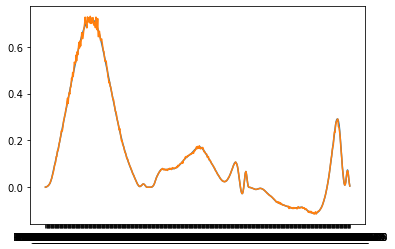

In [27]:
plt.plot(P12_test.iloc[0])
plt.plot(P12_test_noise.iloc[0])

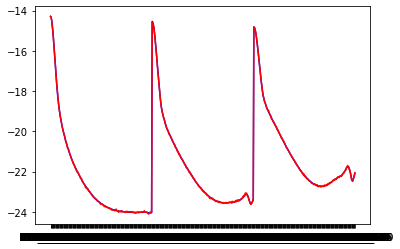

In [28]:
plt.plot(np.log(P11_test).iloc[0],'b')
plt.plot(np.log(P11_test_noise).iloc[0],'r')

In [29]:
P11_450_names =[]
for keys in qoi_test.keys():
    
    if 'P11' in keys:
        if '450' in keys:
            P11_450_names.append(keys)
    
    
    

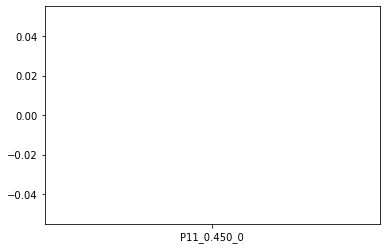

In [30]:
plt.plot((np.log(qoi_test[P11_450_names])).iloc[5],'r.')
plt.plot((np.log(qoi_test_noise[P11_450_names])).iloc[5],'b.')


In [31]:
REL_ERROR = (qoi_test[P11_450_names]-qoi_test_noise[P11_450_names])/qoi_test[P11_450_names]

In [32]:
np.mean(REL_ERROR.mean())

-1.4123861098095291e-05

In [33]:
qoi_test_noise

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.290699   -14.329150   -14.485672   -14.776817   -14.978631   
1       -15.406128   -15.374837   -15.450577   -15.594108   -15.705250   
2       -13.157311   -13.197555   -13.595423   -14.016987   -14.530488   
3       -14.733590   -14.774480   -14.751284   -14.740864   -14.794356   
4       -14.578021   -14.658187   -14.676654   -14.733350   -14.902691   
...            ...          ...          ...          ...          ...   
19995   -13.469008   -13.519867   -13.692284   -14.008227   -14.296526   
19996   -13.573700   -13.662991   -13.898807   -14.281943   -14.750638   
19997   -15.143428   -15.128838   -15.092545   -15.126134   -15.150406   
19998   -13.748361   -13.777961   -13.890949   -14.126392   -14.386948   
19999   -13.627814   -13.779676   -14.052258   -14.512333   -15.074444   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.348690   -15.690324   -16.117032   -16.481045   -16.904129  ...   
1       -15.870579   -16.073651   -16.295046   -16.475034   -16.762263  ...   
2       -15.164459   -15.735750   -16.359462   -16.876631   -17.227074  ...   
3       -14.765228   -14.814492   -14.811919   -14.877883   -14.887227  ...   
4       -15.079758   -15.260427   -15.408763   -15.627871   -15.838360  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.740472   -15.131947   -15.561976   -16.002547   -16.460671  ...   
19996   -15.260123   -15.846061   -16.410074   -16.847903   -17.391772  ...   
19997   -15.164422   -15.261665   -15.296065   -15.384308   -15.389401  ...   
19998   -14.730265   -15.133250   -15.507974   -15.886970   -16.330968  ...   
19999   -15.686426   -16.300053   -16.843791   -17.355294   -17.778983  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.008926       0.010546       0.022955       0.044825   
1           0.015524       0.018944       0.019462       0.017793   
2           0.011548       0.010116       0.008989       0.007487   
3          -0.010138      -0.009341      -0.007361      -0.006090   
4          -0.242768      -0.207243      -0.164477      -0.125633   
...              ...            ...            ...            ...   
19995      -0.027714      -0.026446      -0.011316       0.016927   
19996       0.119710       0.080188       0.046949       0.006112   
19997      -0.126391      -0.111391      -0.090113      -0.072231   
19998      -0.266063      -0.272268      -0.282464      -0.262642   
19999      -0.009712      -0.000818       0.010066       0.020302   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064708       0.070858       0.065730       0.043860   
1           0.015499       0.012499       0.008073       0.005092   
2           0.005858       0.004556       0.003325       0.001861   
3          -0.004658      -0.003293      -0.002223      -0.001343   
4          -0.089890      -0.060512      -0.038101      -0.020554   
...              ...            ...            ...            ...   
19995       0.049774       0.076216       0.076981       0.052316   
19996      -0.027695      -0.049501      -0.049937      -0.033804   
19997      -0.055867      -0.037519      -0.025599      -0.014128   
19998      -0.234267      -0.180273      -0.128291      -0.076937   
19999       0.026814       0.028382       0.024442       0.016949   

       P12_0.630_178  P12_0.630_179  
0           0.020169       0.005328  
1           0.002297       0.000589  
2           0.000866       0.000217  
3          -0.000584      -0.000144  
4          -0.008822      -0.002138  
...              ...            ...  
19995       0.025972       0.006552  
19996      -0.014027      -0.003219  
19997      -0.006734      -0.001695  
19998      -0.034614      -0.008678  
19999       0.008682       0.002328  

[20000 rows x 1077 columns]

In [34]:
qoi_test

P11_0.450_0  P11_0.450_1  P11_0.450_2  P11_0.450_3  P11_0.450_4  \
0       -14.281905   -14.332187   -14.477527   -14.704235   -14.995637   
1       -15.369892   -15.391272   -15.454429   -15.556539   -15.693613   
2       -13.163498   -13.269936   -13.568338   -14.012243   -14.553216   
3       -14.734229   -14.736286   -14.742458   -14.752693   -14.766988   
4       -14.615775   -14.634811   -14.691043   -14.781832   -14.903598   
...            ...          ...          ...          ...          ...   
19995   -13.471070   -13.530708   -13.702360   -13.968277   -14.307416   
19996   -13.582496   -13.669853   -13.917488   -14.292192   -14.757324   
19997   -15.110758   -15.114857   -15.127031   -15.147241   -15.175241   
19998   -13.720382   -13.769295   -13.911328   -14.134009   -14.421893   
19999   -13.613795   -13.728049   -14.043843   -14.504845   -15.056597   

       P11_0.450_5  P11_0.450_6  P11_0.450_7  P11_0.450_8  P11_0.450_9  ...  \
0       -15.335839   -15.710499   -16.106760   -16.512932   -16.917604  ...   
1       -15.861208   -16.054745   -16.269814   -16.502406   -16.748644  ...   
2       -15.147923   -15.755260   -16.336563   -16.855195   -17.295654  ...   
3       -14.785228   -14.807387   -14.833391   -14.863078   -14.896381  ...   
4       -15.052213   -15.223601   -15.413860   -15.619505   -15.837136  ...   
...            ...          ...          ...          ...          ...  ...   
19995   -14.699988   -15.128183   -15.575655   -16.027067   -16.466732  ...   
19996   -15.279204   -15.826173   -16.367481   -16.872268   -17.316948  ...   
19997   -15.210684   -15.253267   -15.302642   -15.358318   -15.419911  ...   
19998   -14.759481   -15.132167   -15.526096   -15.927806   -16.323326  ...   
19999   -15.654047   -16.257151   -16.831466   -17.344860   -17.786594  ...   

       P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0           0.009332       0.010643       0.022662       0.043431   
1           0.015878       0.018746       0.019358       0.018103   
2           0.011556       0.010341       0.009030       0.007616   
3          -0.010240      -0.008920      -0.007501      -0.006055   
4          -0.242960      -0.207220      -0.167870      -0.128450   
...              ...            ...            ...            ...   
19995      -0.026660      -0.025800      -0.011231       0.016919   
19996       0.124190       0.085644       0.045158       0.005981   
19997      -0.131620      -0.111700      -0.091799      -0.072599   
19998      -0.274880      -0.283120      -0.280240      -0.262590   
19999      -0.010206      -0.000796       0.010055       0.020072   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.064713       0.073603       0.063783       0.042183   
1           0.015491       0.012088       0.008447       0.005066   
2           0.006125       0.004613       0.003166       0.001884   
3          -0.004652      -0.003351      -0.002209      -0.001271   
4          -0.092306      -0.061773      -0.037827      -0.020372   
...              ...            ...            ...            ...   
19995       0.051331       0.075070       0.073761       0.051904   
19996      -0.027905      -0.049690      -0.051267      -0.034185   
19997      -0.054749      -0.038806      -0.025225      -0.014351   
19998      -0.228760      -0.181380      -0.127360      -0.075856   
19999       0.026723       0.028192       0.024330       0.016850   

       P12_0.630_178  P12_0.630_179  
0           0.020225       0.005215  
1           0.002352       0.000603  
2           0.000872       0.000224  
3          -0.000574      -0.000145  
4          -0.008731      -0.002131  
...              ...            ...  
19995       0.025579       0.006666  
19996      -0.014282      -0.003060  
19997      -0.006427      -0.001614  
19998      -0.034748      -0.008803  
19999       0.008576       0.002313  

[20000 rows x 1077 columns]

### Predictions

In [35]:
dvar_pred = surr.sample_n_tries(qoi_test_noise.values, batch_size=8, n_tries=1)

In [36]:
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)
dvar_pred

V_tot  R_median       GSD         n     k_532       AAE
0      2255.462702  1.367103  1.420631  1.344939  0.060631  5.777887
1      1170.013674  0.867367  1.408168  1.559415  0.171191  1.056955
2      5042.265545  1.969391  1.403721  1.559583  0.187779  1.109580
3      4957.051165  0.260383  1.401690  1.331395  0.038533  4.369042
4      2481.895919  0.814349  1.446298  1.435062  0.121042  3.171140
...            ...       ...       ...       ...       ...       ...
19995  4625.423716  1.473746  1.412581  1.337182  0.049179  4.690871
19996  3503.428893  1.833686  1.403555  1.467511  0.011917  5.630699
19997  2095.563271  0.384155  1.431053  1.390517  0.043811  3.173240
19998  3956.577113  1.339392  1.407858  1.561476  0.014406  4.507345
19999  3031.327071  2.036294  1.417731  1.336789  0.100914  1.164550

[20000 rows x 6 columns]

In [37]:
dvar_test

V_tot  R_median       GSD         n     k_532       AAE
0      2315.678911  1.360143  1.422027  1.345160  0.060143  5.833945
1      1121.450456  0.871451  1.422156  1.560918  0.172217  1.027340
2      4962.553150  2.033473  1.405489  1.556752  0.179643  1.194336
3      4874.291655  0.258148  1.404925  1.331706  0.039514  4.331665
4      2536.972303  0.806500  1.444872  1.436442  0.118185  3.215479
...            ...       ...       ...       ...       ...       ...
19995  4764.529527  1.494872  1.414259  1.333477  0.047427  4.642539
19996  3534.192530  1.835515  1.405211  1.468337  0.012928  5.740662
19997  2015.697397  0.385029  1.430910  1.390257  0.042194  3.183546
19998  3989.475902  1.355483  1.409619  1.563611  0.013500  4.484978
19999  3102.600374  2.073354  1.426555  1.338385  0.098061  1.239737

[20000 rows x 6 columns]

In [38]:
abs_error_iv = np.abs(dvar_test-dvar_pred)
abs_error_iv

V_tot  R_median       GSD         n     k_532       AAE
0       60.216209  0.006961  0.001396  0.000220  0.000488  0.056058
1       48.563219  0.004084  0.013987  0.001503  0.001026  0.029616
2       79.712395  0.064082  0.001768  0.002832  0.008136  0.084755
3       82.759510  0.002235  0.003235  0.000311  0.000981  0.037377
4       55.076384  0.007849  0.001426  0.001380  0.002856  0.044340
...           ...       ...       ...       ...       ...       ...
19995  139.105810  0.021126  0.001678  0.003705  0.001752  0.048332
19996   30.763637  0.001829  0.001655  0.000826  0.001011  0.109963
19997   79.865874  0.000874  0.000143  0.000260  0.001617  0.010306
19998   32.898789  0.016090  0.001761  0.002135  0.000905  0.022366
19999   71.273302  0.037060  0.008824  0.001596  0.002852  0.075187

[20000 rows x 6 columns]

In [39]:
abs_error_iv.describe()

V_tot      R_median           GSD             n         k_532  \
count  20000.000000  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean      39.287517  1.335877e-02  4.861904e-03  2.459841e-03  1.213180e-03   
std       36.653634  1.282539e-02  4.101151e-03  2.194556e-03  1.349248e-03   
min        0.000069  4.569264e-07  4.463629e-09  1.461803e-07  6.260736e-08   
25%       13.513112  4.561546e-03  1.768680e-03  8.834786e-04  4.017422e-04   
50%       29.478664  9.916711e-03  3.826724e-03  1.918200e-03  8.736896e-04   
75%       54.007489  1.834257e-02  6.842424e-03  3.423034e-03  1.599281e-03   
max      592.112759  2.359494e-01  3.438892e-02  3.551064e-02  2.520926e-02   

                AAE  
count  2.000000e+04  
mean   9.214997e-02  
std    1.996302e-01  
min    1.683066e-07  
25%    2.322713e-02  
50%    5.073200e-02  
75%    9.386412e-02  
max    4.761447e+00

In [40]:
rel_error_iv = abs_error_iv / (dvar_test) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_test.columns).abs()

In [41]:
rel_error_iv.describe()

V_tot      R_median           GSD             n         k_532  \
count  20000.000000  20000.000000  2.000000e+04  20000.000000  20000.000000   
mean       6.826847      1.272541  3.409943e-01      0.166903      6.369599   
std      162.526125      1.544915  2.873422e-01      0.148234     52.850932   
min        0.000004      0.000036  3.125729e-07      0.000011      0.000081   
25%        0.682195      0.408319  1.242059e-01      0.060996      0.782549   
50%        1.471479      0.892089  2.685201e-01      0.131656      1.754457   
75%        2.761619      1.616225  4.798581e-01      0.232104      3.393133   
max    19962.458151     44.769744  2.446274e+00      2.593660   3500.622335   

                AAE  
count  20000.000000  
mean       2.710288  
std        7.073085  
min        0.000004  
25%        0.612231  
50%        1.374179  
75%        2.780313  
max      393.430151

In [42]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
abs_error_table_iv

V_tot  R_median     GSD       n   k_532     AAE
50%   29.4787    0.0099  0.0038  0.0019  0.0009  0.0507
75%   54.0075    0.0183  0.0068  0.0034  0.0016  0.0939
90%   84.8996    0.0292  0.0105  0.0052  0.0026  0.1680
95%  108.0714    0.0372  0.0129  0.0065  0.0033  0.2662
99%  168.2396    0.0577  0.0186  0.0097  0.0060  0.8722

In [43]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
rel_error_table_iv

V_tot  R_median     GSD       n    k_532      AAE
50%   1.4715    0.8921  0.2685  0.1317   1.7545   1.3742
75%   2.7616    1.6162  0.4799  0.2321   3.3931   2.7803
90%   5.0711    2.6357  0.7335  0.3486   7.3522   5.3933
95%   8.4875    3.4962  0.9092  0.4381  14.3643   8.3925
99%  39.8847    7.2744  1.2996  0.6493  78.7663  22.6629

In [44]:
rel_error_iv.mean()

V_tot       6.826847
R_median    1.272541
GSD         0.340994
n           0.166903
k_532       6.369599
AAE         2.710288
dtype: float64

# Weighted MAPE
   $ {\displaystyle {\mbox{WMAPE}}={\frac {\sum _{t=1}^{n}\left|A_{t}-F_{t}\right|}{\sum _{t=1}^{n}\left|A_{t}\right|}}}$

where A is a vector of the actual data and F is the forecast. The advantage of this metric over MAPE is that this overcomes the 'infinite error' issue

In [45]:
dvar_test

V_tot  R_median       GSD         n     k_532       AAE
0      2315.678911  1.360143  1.422027  1.345160  0.060143  5.833945
1      1121.450456  0.871451  1.422156  1.560918  0.172217  1.027340
2      4962.553150  2.033473  1.405489  1.556752  0.179643  1.194336
3      4874.291655  0.258148  1.404925  1.331706  0.039514  4.331665
4      2536.972303  0.806500  1.444872  1.436442  0.118185  3.215479
...            ...       ...       ...       ...       ...       ...
19995  4764.529527  1.494872  1.414259  1.333477  0.047427  4.642539
19996  3534.192530  1.835515  1.405211  1.468337  0.012928  5.740662
19997  2015.697397  0.385029  1.430910  1.390257  0.042194  3.183546
19998  3989.475902  1.355483  1.409619  1.563611  0.013500  4.484978
19999  3102.600374  2.073354  1.426555  1.338385  0.098061  1.239737

[20000 rows x 6 columns]

In [46]:
if case == 'unimodal':
    dvar_test['k_630']=dvar_test['k_532']*(630/532)**(1-dvar_test['AAE'])
    dvar_test['k_450']=dvar_test['k_532']*(450/532)**(1-dvar_test['AAE'])
    
    dvar_pred['k_630']=dvar_pred['k_532']*(630/532)**(1-dvar_pred['AAE'])
    dvar_pred['k_450']=dvar_pred['k_532']*(450/532)**(1-dvar_pred['AAE'])
    
    
    
elif case == 'bimodal':
    dvar_test['k_fine_630']=dvar_test['k_fine_532']*(630/532)**(1-dvar_test['AAE_fine'])
    dvar_test['k_coarse_630']=dvar_test['k_coarse_532']*(630/532)**(1-dvar_test['AAE_coarse'])

    dvar_test['k_fine_450']=dvar_test['k_fine_532']*(450/532)**(1-dvar_test['AAE_fine'])
    dvar_test['k_coarse_450']=dvar_test['k_coarse_532']*(450/532)**(1-dvar_test['AAE_coarse'])

    dvar_pred['k_fine_630']=dvar_pred['k_fine_532']*(630/532)**(1-dvar_pred['AAE_fine'])
    dvar_pred['k_coarse_630']=dvar_pred['k_coarse_532']*(630/532)**(1-dvar_pred['AAE_coarse'])

    dvar_pred['k_fine_450']=dvar_pred['k_fine_532']*(450/532)**(1-dvar_pred['AAE_fine'])
    dvar_pred['k_coarse_450']=dvar_pred['k_coarse_532']*(450/532)**(1-dvar_pred['AAE_coarse'])




In [47]:
dvar_test

V_tot  R_median       GSD         n     k_532       AAE  \
0      2315.678911  1.360143  1.422027  1.345160  0.060143  5.833945   
1      1121.450456  0.871451  1.422156  1.560918  0.172217  1.027340   
2      4962.553150  2.033473  1.405489  1.556752  0.179643  1.194336   
3      4874.291655  0.258148  1.404925  1.331706  0.039514  4.331665   
4      2536.972303  0.806500  1.444872  1.436442  0.118185  3.215479   
...            ...       ...       ...       ...       ...       ...   
19995  4764.529527  1.494872  1.414259  1.333477  0.047427  4.642539   
19996  3534.192530  1.835515  1.405211  1.468337  0.012928  5.740662   
19997  2015.697397  0.385029  1.430910  1.390257  0.042194  3.183546   
19998  3989.475902  1.355483  1.409619  1.563611  0.013500  4.484978   
19999  3102.600374  2.073354  1.426555  1.338385  0.098061  1.239737   

          k_630     k_450  
0      0.026560  0.135085  
1      0.171423  0.173007  
2      0.173836  0.185583  
3      0.022496  0.069018  
4      0.081261  0.171249  
...         ...       ...  
19995  0.025619  0.087264  
19996  0.005800  0.028586  
19997  0.029169  0.060812  
19998  0.007489  0.024194  
19999  0.094166  0.102077  

[20000 rows x 8 columns]

In [48]:
dvar_pred

V_tot  R_median       GSD         n     k_532       AAE  \
0      2255.462702  1.367103  1.420631  1.344939  0.060631  5.777887   
1      1170.013674  0.867367  1.408168  1.559415  0.171191  1.056955   
2      5042.265545  1.969391  1.403721  1.559583  0.187779  1.109580   
3      4957.051165  0.260383  1.401690  1.331395  0.038533  4.369042   
4      2481.895919  0.814349  1.446298  1.435062  0.121042  3.171140   
...            ...       ...       ...       ...       ...       ...   
19995  4625.423716  1.473746  1.412581  1.337182  0.049179  4.690871   
19996  3503.428893  1.833686  1.403555  1.467511  0.011917  5.630699   
19997  2095.563271  0.384155  1.431053  1.390517  0.043811  3.173240   
19998  3956.577113  1.339392  1.407858  1.561476  0.014406  4.507345   
19999  3031.327071  2.036294  1.417731  1.336789  0.100914  1.164550   

          k_630     k_450  
0      0.027031  0.134910  
1      0.169551  0.172831  
2      0.184332  0.191255  
3      0.021800  0.067727  
4      0.083851  0.174090  
...         ...       ...  
19995  0.026349  0.091222  
19996  0.005447  0.025871  
19997  0.030339  0.063034  
19998  0.007962  0.025913  
19999  0.098145  0.103732  

[20000 rows x 8 columns]

In [49]:
def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [50]:
wMAPE_dvar = wmape(dvar_test, dvar_pred)
wMAPE_dvar = pd.DataFrame(wMAPE_dvar).T
wMAPE_dvar

V_tot  R_median       GSD         n    k_532       AAE     k_630  \
0  1.575025  1.007531  0.341169  0.167901  1.93191  2.289544  2.167554   

      k_450  
0  2.146339

In [ ]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
wMAPE_qoi